In [9]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import skimage

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import cv2
import functions
from utils.unet_model import construct_unet

In [55]:
def load_dataset(root, channeled=True):
    if channeled:
        transformers = functions.Compose(
            [
                functions.ChanneledFixResize(256),
                functions.ToTensor(),
                functions.Normalize(),
            ]
        )
    else:
        transformers = functions.Compose(
            [functions.FixResize(256), functions.ToTensor(), functions.Normalize()]
        )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return val_dataset

In [ ]:
def load_device_and_model(weight_path):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    unet = construct_unet(len(category_mapping))
    unet = torch.nn.DataParallel(unet)

    checkpoint = torch.load(weight_path, map_location=device)
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v

    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)

    return device, model

In [47]:
def show(mask, raw_img, test_res, retrained, layers_to_render=None):
    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 12))

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")

    clim = (0, 4)
    im = ax[1].imshow(
        mask_cpu,
        cmap="viridis",
        clim=clim,
    )
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    if layers_to_render is not None:
        test_res = np.where(np.isin(test_res, layers_to_render), test_res, 0)

    ax[2].imshow(test_res, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    if retrained:
        ax[2].set_title("Retrained Model Prediction")
    else:
        ax[2].set_title("Model Prediction")


def show_two(mask, raw_img, test_res1, test_res2):
    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=4, figsize=(12, 12))

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")
    ax[0].set_title("EL Image")

    clim = (0, 4)
    im = ax[1].imshow(mask_cpu, cmap="viridis", clim=clim)
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(test_res1, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()
    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    ax[2].set_title("Model Prediction")

    ax[3].imshow(test_res2, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()
    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[3].legend(handles=handles, fontsize="x-small")
    ax[3].axis("off")
    ax[3].set_title("Retrained Model Prediction")


def inference_and_show(
    idx, root, weight_path, retrained, batch_size=1, layers_to_render=None
):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device, model = load_device_and_model(weight_path)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = val_loader.dataset.__getraw__(idx)
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res = np.argmax(test_res, axis=0)

    show(mask, raw_img, test_res, retrained, layers_to_render=layers_to_render)


def inference_and_show_two(idx, root, weight_path1, weight_path2):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    device, model1 = load_device_and_model(weight_path1)
    device, model2 = load_device_and_model(weight_path2)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = val_loader.dataset.__getraw__(idx)

    test_res1 = model1(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res1 = np.argmax(test_res1, axis=0)

    test_res2 = model2(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res2 = np.argmax(test_res2, axis=0)

    show_two(mask, raw_img, test_res1, test_res2)

In [50]:
def two_row_inference_and_show(idx, root, weight_path, threshold=0.5):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = load_device_and_model(weight_path)

    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)

    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = val_loader.dataset.__getraw__(idx)

    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 4, H, W]
    probs = torch.sigmoid(logits)  # shape: [1, 4, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [4, H, W]

    # Ground truth is assumed to be already a 4-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [4, H, W]

    # --- Visualization ---
    # Create a grid with 3 rows and 4 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = len(category_mapping)
    class_names = [f"({k}) {v}" for k, v in category_mapping.items()]

    fig, axs = plt.subplots(3, n_classes, figsize=(4 * n_classes, 12))

    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert("L"), cmap="viridis")
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis("off")
    for j in range(1, n_classes):
        axs[0, j].axis("off")

    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap="viridis")
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis("off")

    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap="viridis")
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis("off")

    fig.suptitle("Retrained Model Prediction", fontsize=16)

    # plt.tight_layout()
    plt.show()

## Inference w/ Magic Values

### LineCorners

In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'
# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/")
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt"
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/")
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/checkpoints/line_corners_checkpoint2/epoch_30/model.pt"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/checkpoints/line_corners_proper_data_checkpoint5/epoch_30/model.pt"


inference_and_show(1, root, weight_path)
inference_and_show(2, root, weight_path)
inference_and_show(3, root, weight_path)
inference_and_show(4, root, weight_path)
inference_and_show(5, root, weight_path)
inference_and_show(6, root, weight_path)
inference_and_show(7, root, weight_path)
inference_and_show(18, root, weight_path)
inference_and_show(30, root, weight_path)

TypeError: inference_and_show() missing 1 required positional argument: 'retrained'

### LineCorners on Original Weights (does not detect corners)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_64133/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

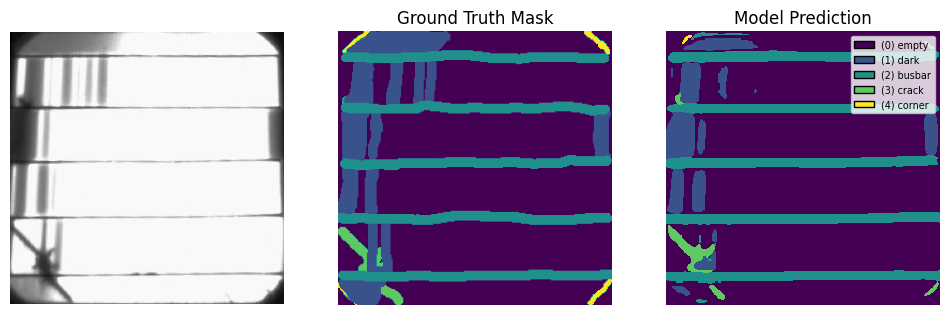

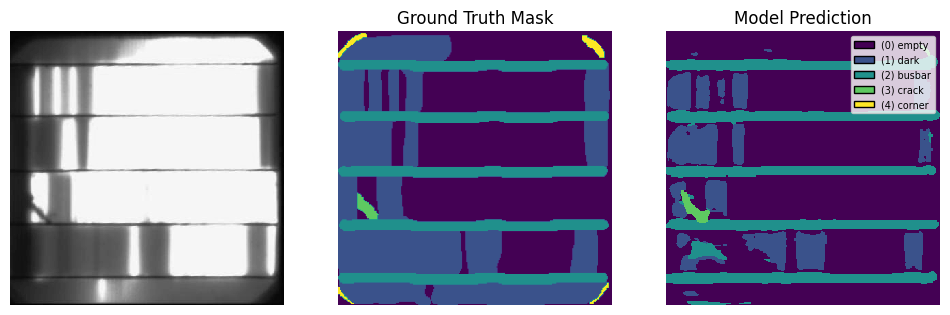

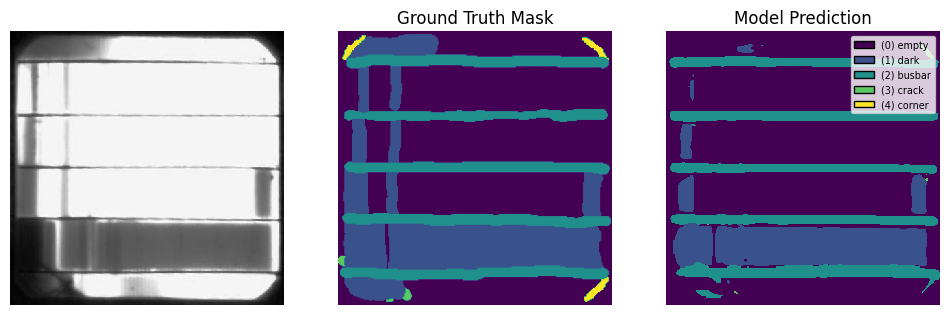

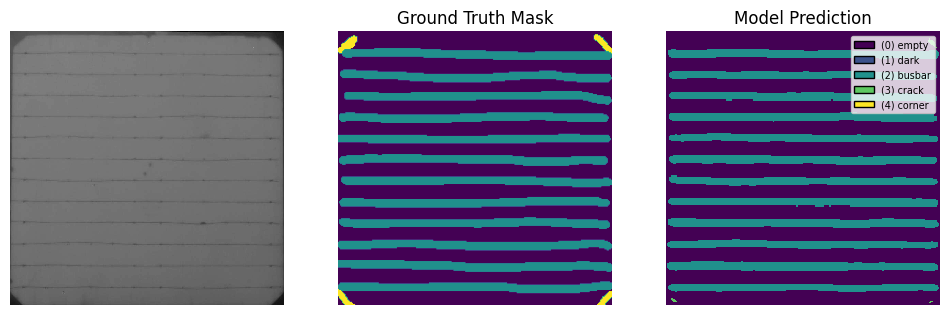

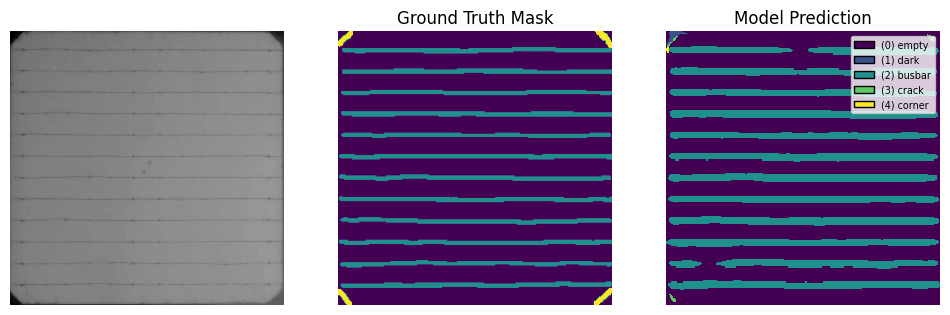

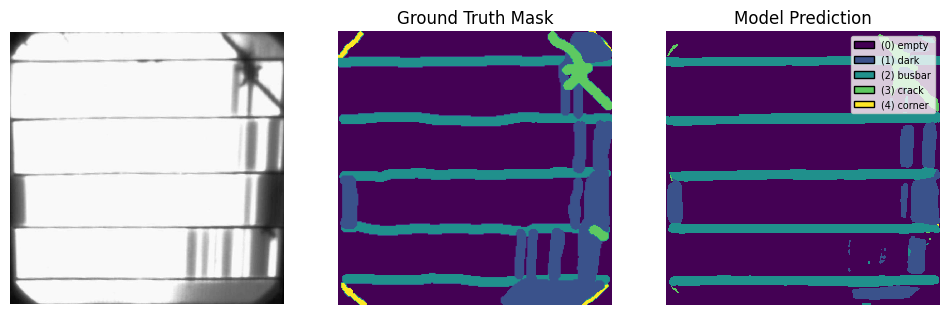

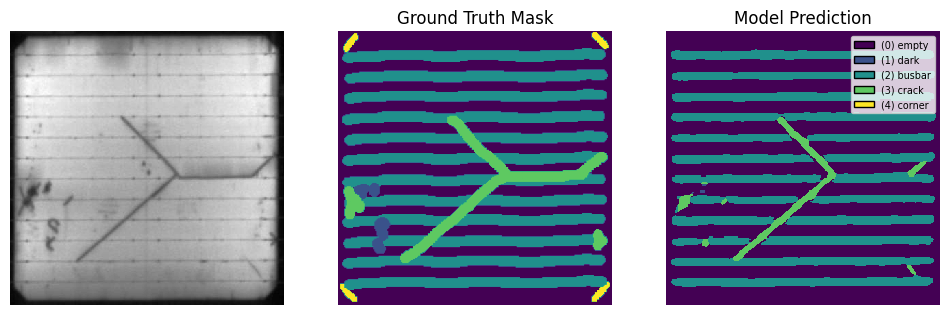

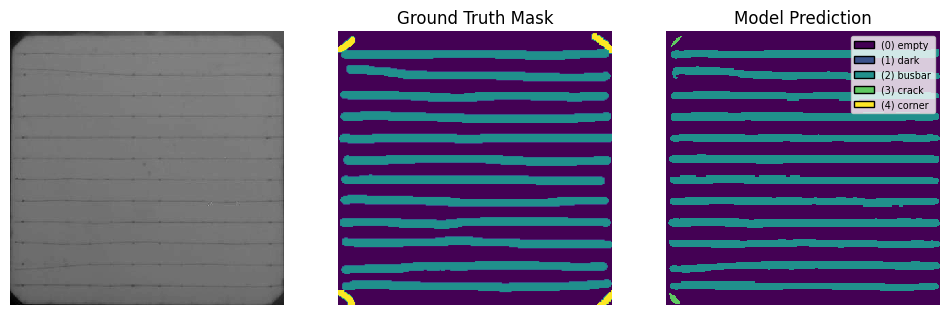

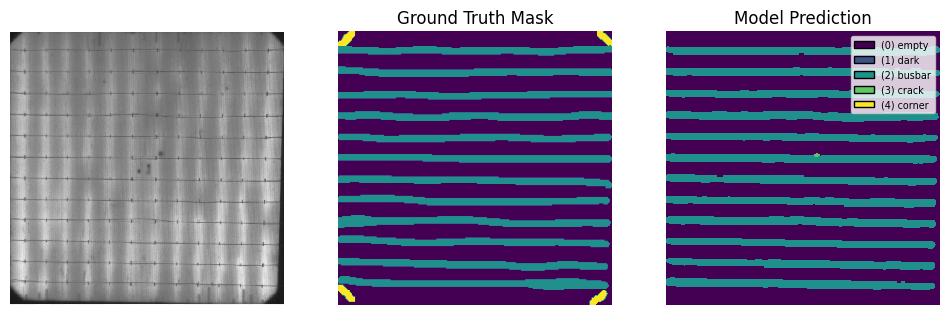

In [23]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/")
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/checkpoints/line_corners_og_weights_checkpoint7/epoch_30/model.pt"


inference_and_show(1, root, weight_path)
inference_and_show(2, root, weight_path)
inference_and_show(3, root, weight_path)
inference_and_show(4, root, weight_path)
inference_and_show(5, root, weight_path)
inference_and_show(6, root, weight_path)
inference_and_show(7, root, weight_path)
inference_and_show(18, root, weight_path)
inference_and_show(30, root, weight_path)

### Triangle Corners

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_64133/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

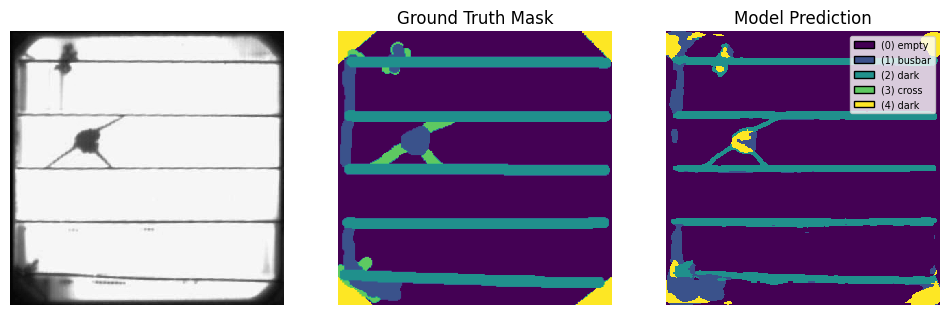

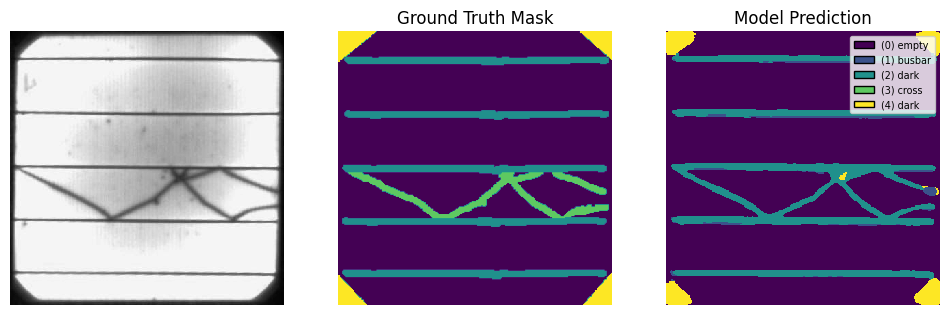

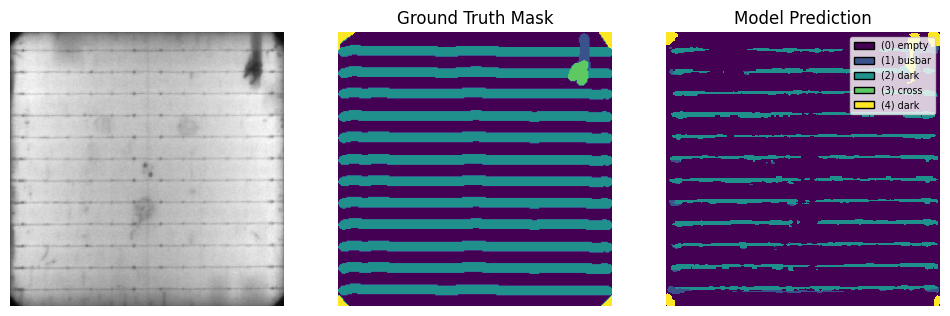

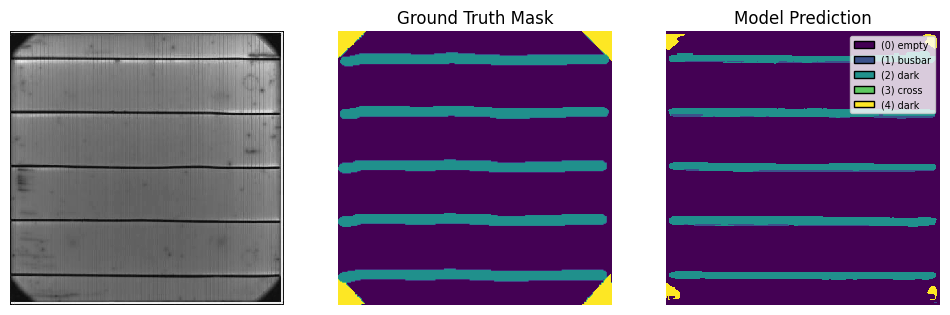

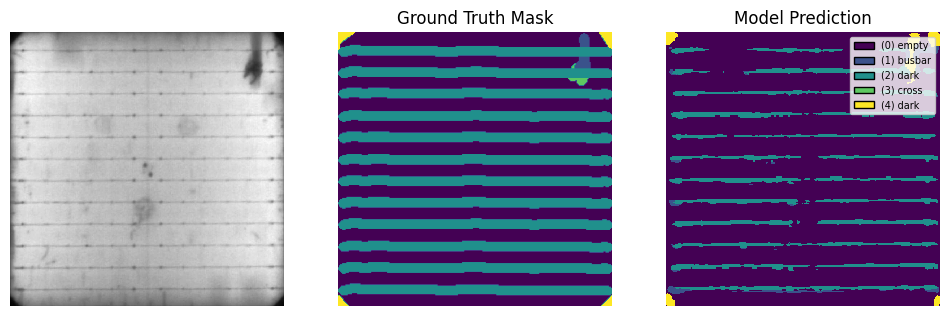

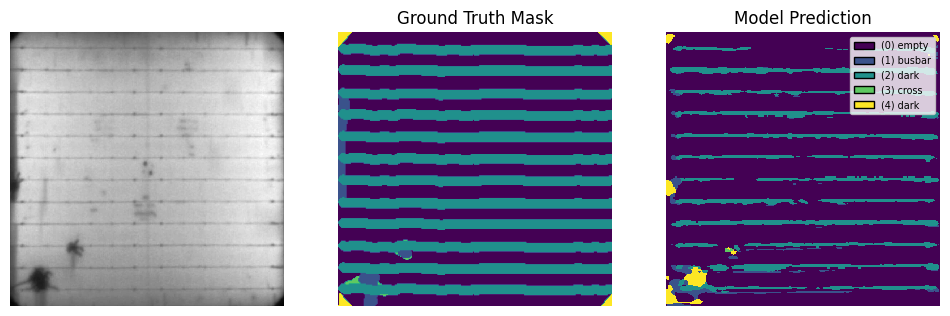

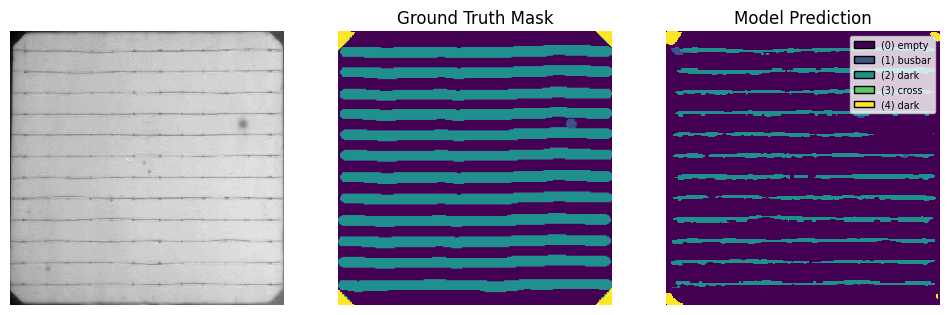

In [26]:
category_mapping = {0: "empty", 1: "busbar", 2: "dark", 3: "cross", 4: "dark"}
# my model
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/")
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt"

inference_and_show(2, root, weight_path)
inference_and_show(4, root, weight_path)
inference_and_show(7, root, weight_path)
inference_and_show(18, root, weight_path)
inference_and_show(30, root, weight_path)
inference_and_show(40, root, weight_path)
inference_and_show(50, root, weight_path)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_64133/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

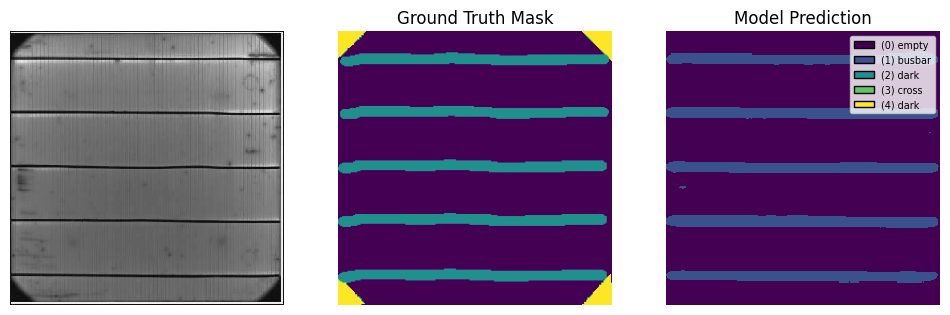

In [16]:
# emma's model
category_mapping = {0: "empty", 1: "busbar", 2: "dark", 3: "cross", 4: "dark"}

# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# weight_path = '/home/osanghi/pvcracks/retrained_pv-vision_model.pt'
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/")
weight_path = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"
)

inference_and_show(18, root, weight_path)

### My model with no corners data

In [10]:
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

# root = Path('/projects/wg-psel-ml/EL_images/osanghi/Norman_ELImages_NoCorners/')
# weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'

# inference_and_show(1, root, weight_path)

### Emma model w/ emma data

In [11]:
# category_mapping = {0: "empty", 1: "busbar", 2: "dark", 3: "cross", 4: "dark"}

# root = Path('/projects/wg-psel-ml/EL_images/eccoope')
# weight_path = '/home/osanghi/pvcracks/retrained_pv-vision_model.pt'

# inference_and_show(1, root, weight_path)

OSError: /projects/wg-psel-ml/EL_images/eccoope/img/train not found.

### OG weights

In [ ]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE')
# weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'

In [ ]:
# inference_and_show(1, root, weight_path)

### CWRU_LBNL model

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_12730/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

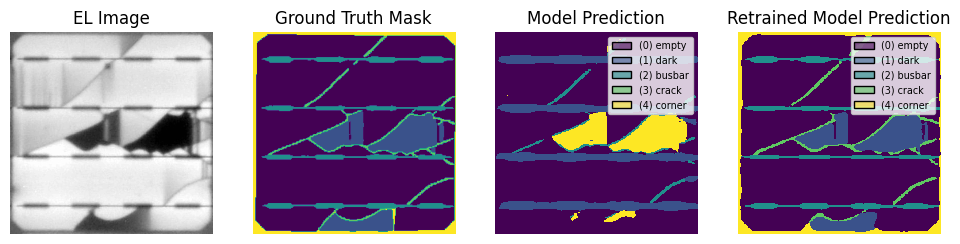

In [11]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)

weight_path1 = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"
)
weight_path2 = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"
# inference_and_show(20, root, weight_path, retrained=True)

inference_and_show_two(20, root, weight_path1, weight_path2)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_12730/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

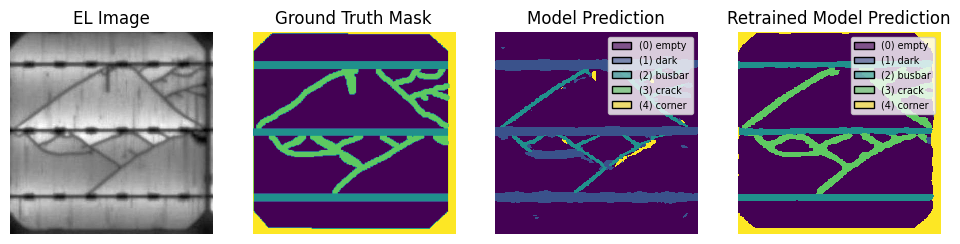

In [12]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)

weight_path1 = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"
)
weight_path2 = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"

# inference_and_show(110, root, weight_path, retrained=True)

inference_and_show_two(110, root, weight_path1, weight_path2)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_12730/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

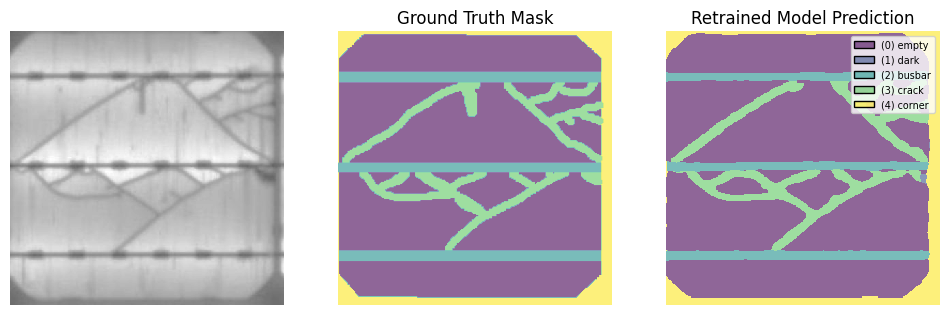

In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)

weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"

inference_and_show(110, root, weight_path, retrained=True)

# combined model

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_70984/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

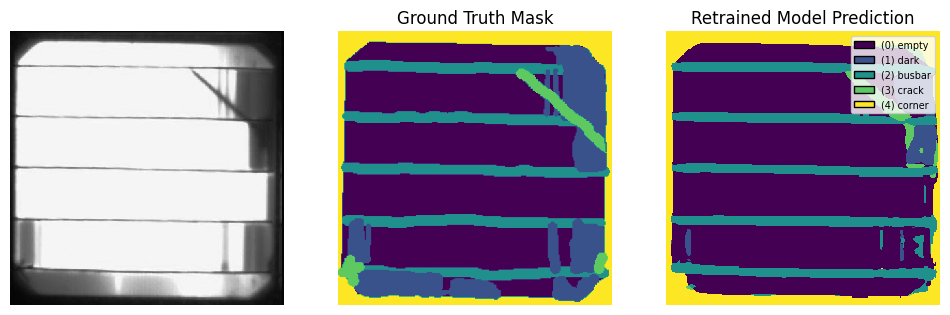

In [43]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/"
)

weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/checkpoints/Combined_CWRU_LBNL_ASU_No_Busbar1/epoch_30/Combined_CWRU_LBNL_ASU_No_Busbar.pt"

inference_and_show(24, root, weight_path, retrained=True)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_70984/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

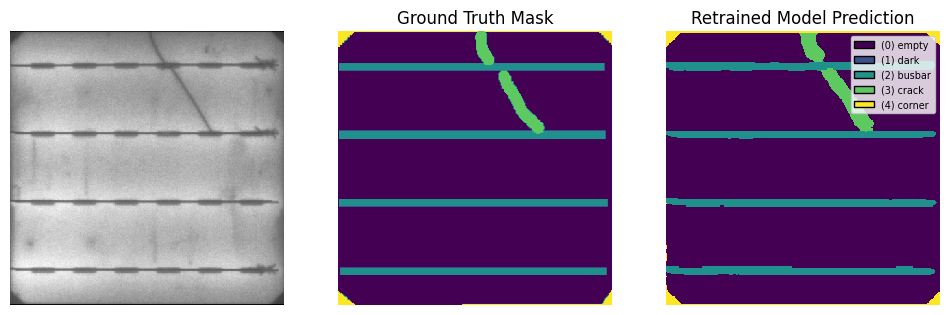

In [44]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/")

weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/checkpoints/CWRU_Dupont_Mono1/epoch_30/CWRU_Dupont_Mono.pt"

inference_and_show(24, root, weight_path, retrained=True)

# PVRW Poster Fig

In [92]:
def show_two_pvrw(mask, raw_img, test_res1, test_res2):
    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

    clim = (0, 4)

    im = ax[0, 0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0, 0].axis("off")
    ax[0, 0].set_title("EL Image", fontsize=20)

    im = ax[0, 1].imshow(mask_cpu, cmap="viridis", clim=clim)
    handles, labels = ax[0, 1].get_legend_handles_labels()
    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[0, 1].legend(handles=handles, fontsize="x-small")
    ax[0, 1].axis("off")
    ax[0, 1].set_title("Ground Truth Mask", fontsize=20)

    old_category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
    old_cmaplist = [cmaplist[i] for i in [0, 2, 3, 4, 1]]

    import matplotlib.colors as mcolors

    old_cmap = mcolors.ListedColormap(old_cmaplist)

    ax[1, 0].imshow(test_res1, cmap=old_cmap, clim=clim, interpolation="None")
    handles, labels = ax[1, 0].get_legend_handles_labels()
    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in old_category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[1, 0].legend(handles=handles, fontsize="x-small")
    ax[1, 0].axis("off")
    ax[1, 0].set_title("Model Prediction", fontsize=20)

    ax[1, 1].imshow(test_res2, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[1, 1].get_legend_handles_labels()
    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[1, 1].legend(handles=handles, fontsize="x-small")
    ax[1, 1].axis("off")
    ax[1, 1].set_title("Retrained Model Prediction", fontsize=20)


def inference_and_show_two_pvrw(idx, root, weight_path1, weight_path2):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    device, model1 = load_device_and_model(weight_path1)
    device, model2 = load_device_and_model(weight_path2)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = val_loader.dataset.__getraw__(idx)

    test_res1 = model1(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res1 = np.argmax(test_res1, axis=0)

    test_res2 = model2(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res2 = np.argmax(test_res2, axis=0)

    show_two_pvrw(mask, raw_img, test_res1, test_res2)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_42379/1706340553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

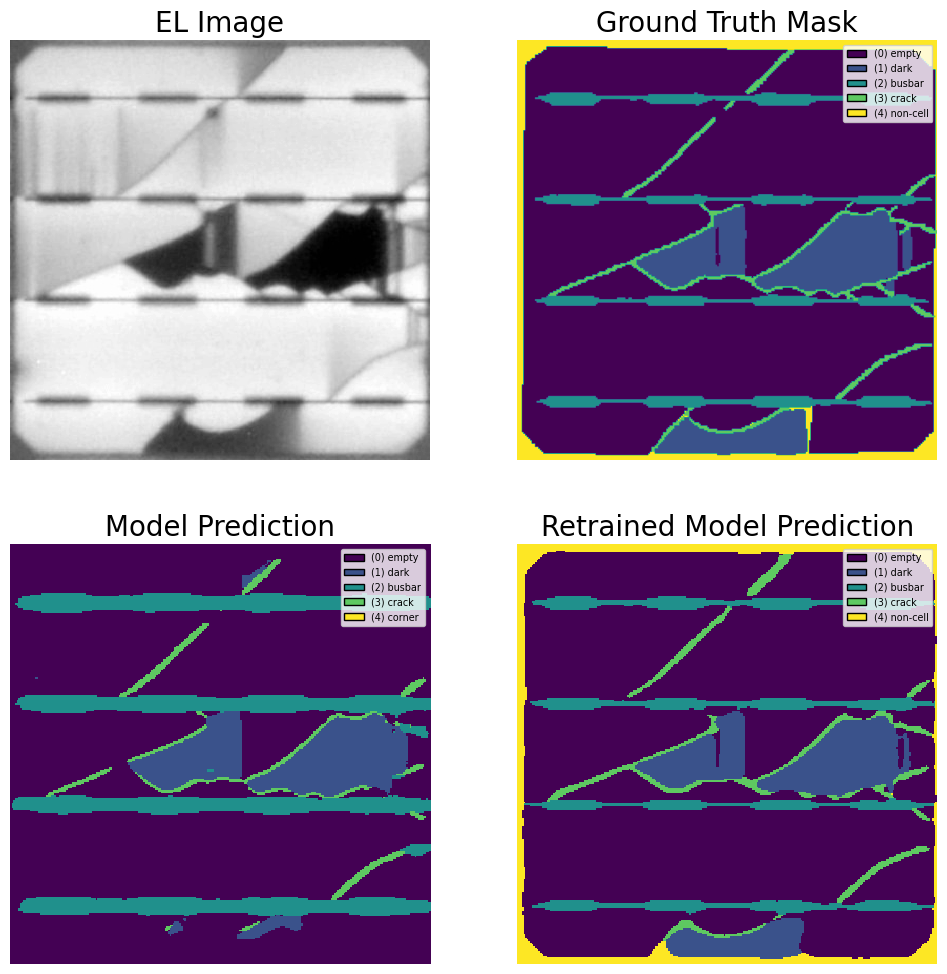

In [93]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)

weight_path1 = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"
)
weight_path2 = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"
# inference_and_show(20, root, weight_path, retrained=True)

inference_and_show_two_pvrw(20, root, weight_path1, weight_path2)

# new figures for paper

In [61]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"
)

weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_Optimized/model.pt"
# other_weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_2/model.pt"

for i in range(0, 101):
    two_row_inference_and_show(i, root, weight_path)

IndexError: index 585 is out of bounds for axis 0 with size 585